<a href="https://colab.research.google.com/github/amey-joshi/am/blob/master/p4/m2p_C03_An_Efficient_Preconditioner_for_Stochastic_Gradient_Descent_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This tutorial is based on the paper [An Efficient Preconditioner for Stochastic
Gradient Descent Optimization of Image Registration](https://drive.google.com/drive/folders/1uGhRukl6ZBdZhOOhfqF1K3DzLT3xN-F_) by Yuchuan Qiao , Boudewijn P. F. Lelieveldt, and Marius Staring. It assumes that the reader has gone through the earlier tutorial on adaptive stochastic gradient algorithm for image registration. This tutorial will reuse the algorithm developed in that tutorial and will just plug in the pre-conditioner in the same algorithm.

We briefly explained the various methods to find extrema of functions in our previous tutorials on adaptive stochastic gradient method and stochastic quasi-Newton methods. The image registration algorithm is an optimization algorithm described as
$$\tag{1}
\hat{\boldsymbol{\mu}} = \mathrm{argmin}_\boldsymbol{\mu}\;\mathcal{C}(I_F, T_\boldsymbol{\mu}(I_M)),
$$
where


*   $I_F$ is the fixed image;
*   $I_M$ is the moving image;
*   $T_\boldsymbol{\mu}$ is a parametric transformation taking the moving image to the fxed image. $\boldsymbol{\mu}$ are the parameters of the transformation.
*   $\mathcal{C}$ is the cost function. It is a measure of the dissimilarity between its arguments.

The optimization consists in finding $\boldsymbol{\mu}$ that minimizes the cost function, that is minimizes the dissimilarity between the moving and the fixed images. A typical gradient descent algorithm is expressed as
$$\tag{2}
\boldsymbol{\mu}_{k+1} = \boldsymbol{\mu} - \gamma_k \boldsymbol{D}_k,
$$
where $\boldsymbol{D}_k$ is either the gradient of $\mathcal{C}$ with respect to $\boldsymbol{\mu}$ or a closely related function. For the purpose of this discussion it is appropriate to let $\boldsymbol{D}_k$ be $\nabla\mathcal{C}_{\boldsymbol{\mu}_k}$, the gradient of $\mathcal{C}$ computed at the $k$-th step. In the next section we explain the idea of a preconditioner.




# The preconditioner
In principle equations (1) and (2) are a perfect definition of an optimization problem. In practice, they fall short if the cost function is ill-conditioned leading to numerical instability. Let us therefore understand what being ill-conditioned means in the context of gradient descent. We know that the gradient descent algorithm finds the direction of the steepest gradient and chooses to descend in the exactly opposite direction. Often times, the function is of the shape of a long narrow valley. If one descends along the "long direction" then one can hit the minimum only after a large number of iterations. In many of these iterations the function changes very little and some optimizers might stop believing that they have found a minimum. On the other hand, if one descends down perpendicular to the "long direction", one will see the value of the function dropping drastically. An adaptive gradient descent algorithm chooses a large 'step size' in the former case in which the function changes gently. It chooses a small step size in the latter case when the value of the function drops very fast. While this idea works well in many situations, it does break when in extreme situations when the valley is very deep and long. In such situations it is beneficial to transform our function so that the descent in all directions is roughly the same.

We recommend going over the lectures in Cornell university's course [Principles of Large-Scale Machine Learning — Spring 2019](https://www.cs.cornell.edu/courses/cs4787/2019sp/) for a deeper understanding of the idea of a condition number of a problem and the preconditioner. In particular, we recommend [lecture 4](https://www.cs.cornell.edu/courses/cs4787/2019sp/notes/lecture4.pdf) and [lecture 7](https://www.cs.cornell.edu/courses/cs4787/2019sp/notes/lecture7.pdf).

With a pre-conditioner, equation (2) becomes
$$\tag{3}
\boldsymbol{\mu}_{k+1} = \boldsymbol{\mu} - \gamma_k \boldsymbol{P} \boldsymbol{D}_k,
$$
where $\boldsymbol{P}$ is the preconditioner matrix. It can either be the same for all iterations or it may be recomputed for each iteration. In the latter case, one might choose to denote it by $\boldsymbol{P}_k$. If $\boldsymbol{P} = \boldsymbol{I}$, the identity matrix, then the we have the normal stochastic gradient algorithm. It is especially important for an image processing application to have $\boldsymbol{P}$ which is easily computed.


# The choice of pre-conditioner
The gradient descent algorithm computes a different set of transformation parameters in each iteration. A change in the parameters changes the transformation by a certain amount. A voxel will be moved to one point $T_{\boldsymbol{\mu}_k}$ and another point by $T_{\boldsymbol{\mu}_{k+1}}$. We denote the incremental displacement in the second transformation by $d_k$. Note that $d_k$ will not be the same for the entire image. Rather, it is a function of the voxel. Thus,
$$\tag{4}
d_k(x_j) = T_{\boldsymbol{\mu}_{k+1}}(x_j) - T_{\boldsymbol{\mu}_{k}}(x_j).
$$
If the parameters do not change drastically across iterations, we can approximate the above equation as
$$\tag{5}
d_k(x_j) = \frac{\partial{T_{\boldsymbol{\mu}_{k}}(x_j)}}{{\partial\boldsymbol{\mu}_{k}}}(\boldsymbol{\mu}_{k+1} - \boldsymbol{\mu}_{k}).
$$
If the image is $d$-dimensional and if the number of parameters is $N_p$ then 
$$\tag{6}
\boldsymbol{J}(x_j) = \frac{\partial{T_{\boldsymbol{\mu}_{k}}(x_j)}}{{\partial\boldsymbol{\mu}_{k}}}
$$
is a $d \times N_p$ matrix. The authors call $J$ the jacobian matrix. However, we will just call it the $J$-matrix. Using equations (3) and (6) in (5) we get
$$\tag{7}
d_k(x_j) = -\gamma_k \boldsymbol{J}(x_j) \boldsymbol{P}\boldsymbol{D}_k 
$$
This paper approximates the preconditioner $\boldsymbol{P}$ by a diagonal matrix so that the product $\boldsymbol{P}\boldsymbol{D}_k$ is very easy to compute. The diagnal elements are
$$\tag{8}
p_i = \frac{\delta}{\mathrm{E}(s)i) + 2\sqrt{\mathrm{Var}(s_i)} + \varepsilon},
$$
where $\delta$ and $\varepsilon$ are constants and $s_i = ||\boldsymbol{J}(x_j)||.||\boldsymbol{D}_k||$, $$||\cdot||$ being the $L^2$ norm of a column of the matrix.

# Implementation
We implement the preconditioner in functions <code>compute_P</code> and <code>compute_q</code> in the code snippet in the cells below. We continue to work with the same binary images we have been using all along and we try the linear transformation $T(x) = \mu_0 + \mu_1 x$ on the image. This code is the same as we used in the tutorial on adaptive stochastic gradient except for the addition of two new functions to compute the preconditioner.

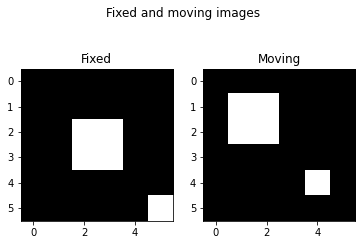

mu = [ 8.76669048e-05 -6.84906639e-07]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from scipy import stats


f = np.zeros(36)
f[14] = f[15] = f[20] = f[21] =  f[35] = 128
ref = Image.new('1', (6, 6))
ref.putdata(f)

m = np.zeros(36)
m[7] = m[8] = m[13] = m[14] = m[28] = 128
tst = Image.new('1', (6, 6))
tst.putdata(m)

plt.figure()
plt.suptitle('Fixed and moving images')
p1 = plt.subplot(121)
p1.set_title('Fixed')
plt.imshow(ref)

p2 = plt.subplot(122)
p2.set_title('Moving')
plt.imshow(tst)

plt.show()

x = f - m # This is the "error" between the images.
C = np.array([[36, np.sum(x)], [np.sum(x), np.sum(x**2)]])/36

DELTA = 0.1
den_sigma_4 = np.zeros(len(x))
delta_sq = DELTA**2

for j in range(0, len(den_sigma_4)):
  a = 1 + x[j]**2
  den_sigma_4[j] = delta_sq/a

sigma_4_sq = np.min(den_sigma_4)/(1 + 2 * np.sqrt(2))
sigma_4 = np.sqrt(sigma_4_sq)

# This is our starting vector
mu_0 = np.array([0, 0])
cov = np.array([[sigma_4_sq, 0], [0, sigma_4_sq]])
mu_samples = []
N = 20 # number of samples

frozen = stats.multivariate_normal(mu_0, cov)
mu_samples = frozen.rvs(10)

random.seed(12111842)

exact_g = []
apprx_g = []
error_g = []

for i in range(len(mu_samples)):
  mu = mu_samples[i]
  g = np.zeros(2)
  for j in range(len(x)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])
    g = g + coeff * X

  exact_g.append(g)

for i in range(len(mu_samples)):
  mu = mu_samples[i]
  g = np.zeros(2)
  # Select a new set of pixels for computation of each approximate gradient
  S = random.sample(range(0, 36), N)
  for j in range(len(S)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])
    g = g + coeff * X

  apprx_g.append(g)

for i in range(len(mu_samples)):
  error_g.append(exact_g[i] - apprx_g[i])
  
trace_C = C[0, 0] + C[1, 1]

s = 0 
for i in range(len(exact_g)):
  g_n = exact_g[i]
  s = s + g_n[0]**2 + g_n[1]**2

sigma_1_sq = 1/(N * trace_C)

all_a = np.zeros(len(x))
sigma_1 = np.sqrt(sigma_1_sq)
coeff = 0.1 / sigma_1

for i in range(len(x)):
  a = (1 + 2 * np.sqrt(2)) * (1 + 3.64 * 1E3 * x[i]**4)
  all_a[i] = coeff/np.sqrt(a)

a_max = np.min(all_a)

s1 = 0
s2 = 0
for i in range(len(exact_g)):
  g = exact_g[i]
  h = apprx_g[i]

  s1 = s1 + (g[0]**2 + g[1]**2)
  s2 = s2 + (h[0]**2 + h[1]**2)

eta = s1/(s1 + s2)
a = a_max * eta
f_min = eta - 1

err_prod = np.zeros(len(error_g) - 1)
zeta = 0.1

for i in range(1, len(error_g)):
  e1 = error_g[i]
  e2 = error_g[i - 1]
  err_prod[i - 1] = np.dot(e1, e2)

omega = zeta * np.std(err_prod)

def our_sigmoid(x):
  # Recall that f_max = 1
  return f_min + (1 - f_min)/(1 - np.exp(-x/omega)/f_min)

def calc_t(prev_t, g_curr, g_prev):
  arg = prev_t + our_sigmoid(np.dot(g_curr, g_prev))
  if arg > 0:
    return arg
  else:
    return 0

# We re-initialize the image data
f = np.zeros(36)
f[14] = f[15] = f[20] = f[21] =  f[35] = 128
m = np.zeros(36)
m[7] = m[8] = m[13] = m[14] = m[28] = 128
# 'Difference' between fixed and moving images.
x = f - m

# Parameters of the algorithm
MAX_ITER = 300 # Maximum number of iterations.
n_iter = 0     # Current iteration.

# Temporary variables
g_prev = np.array([1, 1]) # previous gradient
mu_prev = np.zeros(2)     # previous parameters
prev_t = 0                # previous 'time'

def compute_q(s):
    x = np.sum(s)/len(s)
    y = np.sum(s**2)/len(s)
    
    return x + 2 * np.sqrt(np.abs(y - x**2))

def compute_P(s1, s2):
    q1 = compute_q(s1)
    q2 = compute_q(s2)
    
    p1 = 1/(q1 + 0.01)
    p2 = 1/(q2 + 0.01)
    
    return np.diag([p1, p2])

while n_iter < MAX_ITER:
  n_iter = n_iter + 1
  m = mu_prev[0] + mu_prev[1] * f
  
  # Select a new set of pixels for computation of each approximate gradient
  S = random.sample(range(0, 36), 15)
  g = np.zeros(2)
  
  s1 = 0
  s2 = 0
  for j in range(len(S)):
    # Recall that the data for the fixed image is in the array x
    X = np.array([1, x[j]]) 
    coeff = -2 * ((1 - mu[1]) * x[j] - mu[0])    
    g = g + coeff * X    
    
  s1 = np.zeros(len(S))
  s2 = np.zeros(len(S))
  for j in range(len(S)):
      s1[j] = 1 * g[0]
      s2[j] = x[j] * g[1]
  
  curr_t = calc_t(prev_t, g, g_prev)  
  gamma = a_max/(curr_t + 1) # Recall that A = 1, alpha = 1
  
  # Compute the pre-conditioner
  P = compute_P(s1, s2)

  mu_prev = mu_prev + gamma * np.dot(P, g)
  g_prev = g
  prev_t = curr_t
  
print(f'mu = {mu_prev}')